In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [60]:
data = pd.read_csv('total_population.csv', index_col=0).T
data_en = pd.read_csv('enslaved_population.csv', index_col=0).T
years = data.index.astype(int)

In [61]:
def make_percentiles(data, n_splits=4):
    years = data.index.astype(int)
    percentiles = np.zeros((years.size, n_splits-1))
    for ii, (date, row) in enumerate(data.iterrows()):
        notnull = row.notnull()
        total = notnull.sum()
        keep = sorted(row[notnull].values.astype(int))
        cum_sum = np.cumsum(keep)
        for jj in range(n_splits-1):
            cutoff = cum_sum[-1] * (jj + 1) / n_splits
            idx = np.mod(np.argmin(cum_sum <= cutoff) - 1, cum_sum.size)
            diff = cutoff - cum_sum[idx]
            if idx < total - 1:
                extra = diff / keep[idx+1]
            else:
                extra = 0.
            percentiles[int(ii), jj] = (1 + idx + extra) / total
    return percentiles

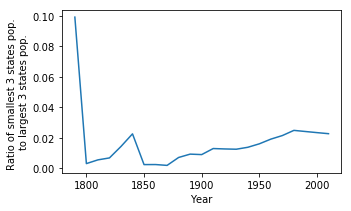

In [62]:
n = 3
bot_n = np.zeros(years.size)
top_n = np.zeros(years.size)
for ii, (date, row) in enumerate(data.iterrows()):
    notnull = row.notnull()
    keep = sorted(row[notnull].values.astype(int))
    bot_n[ii] = np.sum(keep[:n])
    top_n[ii] = np.sum(keep[-n:])
f, ax = plt.subplots(1, figsize=(5, 3))
ax.plot(years, bot_n / top_n)
ax.set_xlabel('Year')
ax.set_ylabel('Ratio of smallest {} states pop. \nto largest {} states pop.'.format(n, n))

In [81]:
def make_time_plots(percentiles, years, faxes):
    f, (ax0, ax1) = faxes
    n_splits = percentiles.shape[1] + 1
    ax0.fill_between(years, 0. * percentiles[:, 0], percentiles[:, 0], label='0-25th percentile')
    print(percentiles[-1, 0] - percentiles[0, 0])
    for ii in range(n_splits-2):
        ax0.fill_between(years, percentiles[:, ii], percentiles[:, ii + 1], label='25-50th percentile')
        print((percentiles[-1, ii+1] - percentiles[-1, ii]) - (percentiles[0, ii+1] - percentiles[0, ii]))
    ax0.fill_between(years, percentiles[:, -1], np.ones_like(percentiles[:, -1]), label='75-100th percentile')
    print((1. - percentiles[-1, ii]) - (1. - percentiles[0, ii]))

    for ii in range(n_splits-1):
        ax1.plot([years[0], years[-1]], [percentiles[0, ii], percentiles[-1, ii]], label='25th percentile')


    for ax in [ax0, ax1]:
        ax.set_yticks([0, .25, .5, .75, 1])
        ax.set_ylim(0, 1)        
        ax.set_ylabel('Senate Fraction')
        ax.set_xlabel('Year')

    ax0.set_xlim(years.min(), years.max())

    ax1.set_xticks([years[0], years[-1]])
    f.tight_layout()

0.0297940967614
0.0296842453513
-0.021885179739
-0.0594783421127


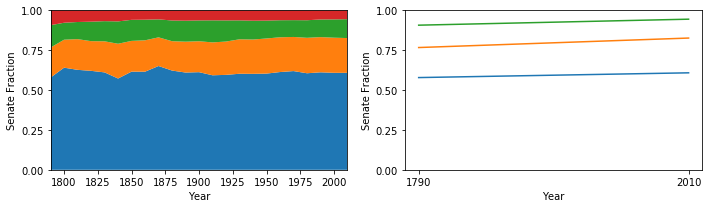

In [82]:
n_splits = 4
percentiles = make_percentiles(data, n_splits)
faxes = plt.subplots(1, 2, figsize=(10, 3))
make_time_plots(percentiles, years, faxes)

0.563972150171 0.197950789588 0.130635118958 0.107441941283
0.608383473249 0.218115168888 0.118395196537 0.0551061613258
0.0444113230785
0.0201643793002
-0.0122399224217
-0.0645757023787


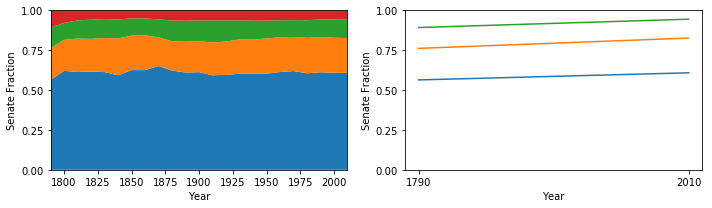

In [91]:
data_no_en = data.copy()
data_en[pd.isnull(data_en)] = 0
data_no_en.loc[data_en.index] -= data_en
percentiles_no_en = make_percentiles(data_no_en, n_splits)
print(percentiles_no_en[0, 0], percentiles_no_en[0, 1] - percentiles_no_en[0, 0],
      percentiles_no_en[0, 2] - percentiles_no_en[0, 1], 1. - percentiles_no_en[0, -1])
print(percentiles_no_en[-1, 0], percentiles_no_en[-1, 1] - percentiles_no_en[-1, 0],
      percentiles_no_en[-1, 2] - percentiles_no_en[-1, 1], 1. - percentiles_no_en[-1, -1])


faxes = plt.subplots(1, 2, figsize=(10, 3))
make_time_plots(percentiles_no_en, years, faxes)
plt.savefig('/Users/jesse/Downloads/frac_in_time.png', dpi=72)

In [85]:
last_n = 5

x = years[-last_n:]
x -= x.min()
y = percentiles[-last_n:, 0]
m, b, r, p, std = stats.linregress(x, y)
print(m, b, r, p, std)

for ii in range(n_splits-2):
    x = years[-last_n:]
    x -= x.min()
    y = percentiles[-last_n:, ii+1] - percentiles[-last_n:, ii]
    m, b, r, p, std = stats.linregress(x, y)
    print(m, b, r, p, std)

x = years[-last_n:]
x -= x.min()
y = 1. - percentiles[-last_n:, -1]
m, b, r, p, std = stats.linregress(x, y)
print(m, b, r, p, std)

-0.000192238790795 0.614547987344 -0.574869702937 0.310649559324 0.000157977166517
6.06732671025e-05 0.217903474564 0.297615605256 0.626734869156 0.000112367705126
0.000305922715257 0.105844237057 0.981935456307 0.00290665872896 3.40350511253e-05
-0.000174357191565 0.0617043010357 -0.919077622561 0.0272956696124 4.31626035238e-05


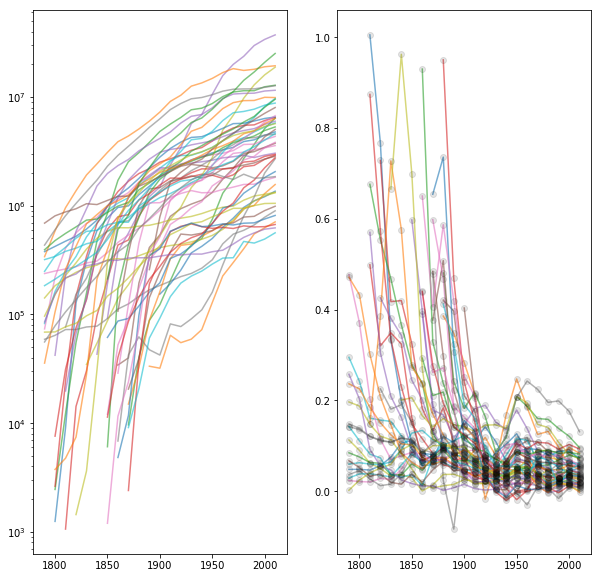

In [68]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
ax0.plot(years, data.values, alpha=.6)
ax0.set_yscale('log')

p = ax1.plot(years, np.gradient(np.log10(data.values), axis=0), alpha=.6)
p = ax1.plot(years, np.gradient(np.log10(data.values), axis=0), 'ok', alpha=.1)
#ax0.set_yscale('log')